In [1]:
import gdown
import csv
import random
import math
import numpy as np
from scipy.spatial.distance import cdist
from keras.models import load_model
from keras.models import Model
from keras.utils import to_categorical
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
!gdown --id 1-0OQTzDJmEu4ndbXari5K4X5rVPleCyA

Downloading...
From: https://drive.google.com/uc?id=1-0OQTzDJmEu4ndbXari5K4X5rVPleCyA
To: /content/images_color.csv
517MB [00:02, 172MB/s]


In [3]:
!gdown --id 1j3cl35Ags6RTkClJ2KZkN7HMCndv4PIA

Downloading...
From: https://drive.google.com/uc?id=1j3cl35Ags6RTkClJ2KZkN7HMCndv4PIA
To: /content/yuvnish_tsr_model_v5.h5
168MB [00:00, 192MB/s]


In [4]:
ydata = []
xdata = []

with open('/content/images_color.csv', 'r') as f:
  reader = csv.reader(f)
  for row in reader:
    if row[0]!='':
      label = row[0]
      image = np.array([float(a)/255.0 for a in row[1:]])
      image = image.reshape((32, 32, 3))
      image = cv.resize(image,(64, 64))
      xdata.append(image)
      ydata.append(label)

img_data = np.array(xdata)
label_data = np.array(ydata).astype("int")
# print(img_data.shape,label_data.shape)

In [5]:
del xdata, ydata

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


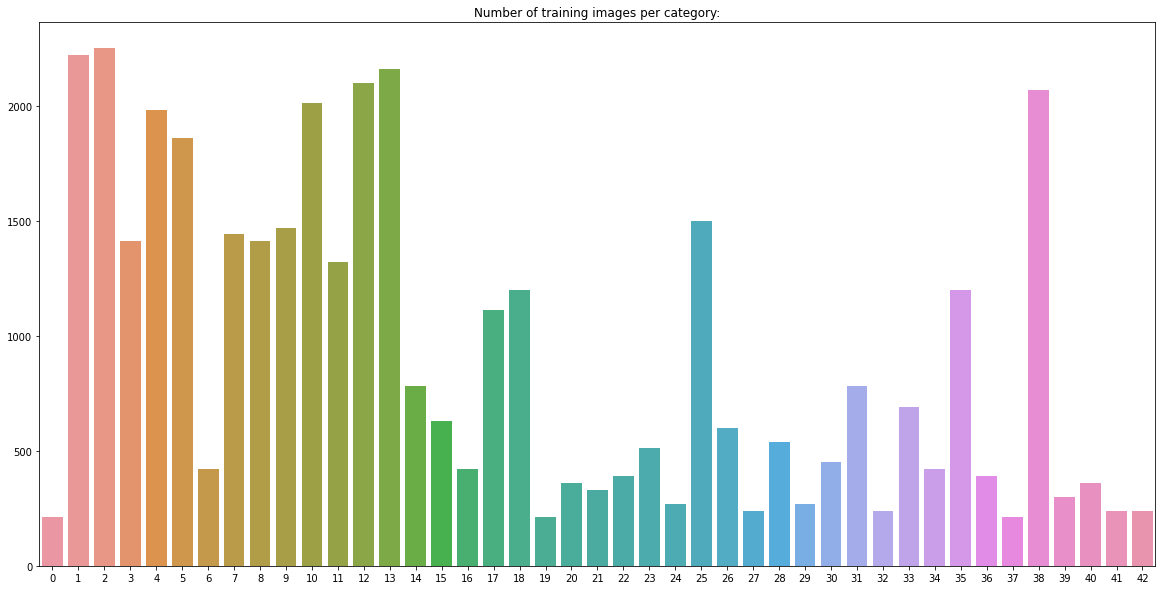

In [6]:
def plot(y):
  category_names = [n for n in range(len(np.unique(y)))]
  label_num = []
  for i in category_names:
    num = sum(y == i)
    label_num.append(num)
  plt.figure(figsize=(20,10))
  sns.barplot(category_names, label_num).set_title("Number of training images per category:")
  plt.show()

plot(label_data)

In [7]:
def difficult_sam(x, y, test_size, ypred):
  num = y.shape[0]
  num_test = int(num*test_size)
  num_train = num-num_test
  mask1 = y == ypred
  mask2 = y != ypred
  del ypred
  x1, y1 = x[mask1], y[mask1]
  x2, y2 = x[mask2], y[mask2]
  del mask1, mask2, x, y
  num_train = num_train-y2.shape[0]
  test_size = num_test/(num_test+num_train)
  xtrain, xtest, ytrain, ytest = train_test_split(x1, y1, test_size=test_size)
  del x1, y1
  xtrain, ytrain = np.concatenate((xtrain, x2), axis=0), np.concatenate((ytrain, y2), axis=0)
  del x2, y2
  return xtrain, xtest, ytrain, ytest

In [8]:
def euc_mat(x):

  model = load_model("/content/yuvnish_tsr_model_v5.h5")
  layer_name = 'fc3'
  intermediate_layer = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
  xvectors= intermediate_layer.predict(x)

  mat = cdist(xvectors, xvectors, metric='euclidean')

  del model
  del xvectors
  return mat

def kennard_stone(x, y, test_size):
  num = y.shape[0]

  x_train = []
  y_train = []
  x_test = []
  y_test = []

  for i in range(len(np.unique(y))):
    mask = y == i
    class_num = sum(mask)
    cnum_test = int(class_num*test_size)
    cx = x[mask]
    cy = y[mask]
    eucl_mat = euc_mat(cx)

    select_p = []
    remain_p = [n for n in range(class_num)]
    first_2pts = np.unravel_index(np.argmax(eucl_mat), eucl_mat.shape)
    select_p.append(first_2pts[0])
    select_p.append(first_2pts[1])
    remain_p.remove(first_2pts[0])
    remain_p.remove(first_2pts[1])
    
    for _ in range(cnum_test-2):
      select_distance = eucl_mat[select_p, :]
      min_distance = select_distance[:, remain_p]
      min_distance = np.min(min_distance, axis=0)
      max_min_distance = np.max(min_distance)
      points = np.argwhere(select_distance == max_min_distance)[:, 1].tolist()
      for point in points:
        if point in select_p:
          pass
        else:
          select_p.append(point)
          remain_p.remove(point)
          break
      
    del eucl_mat, select_distance
    
    xtrain, ytrain = cx[remain_p], cy[remain_p]
    xtest, ytest = cx[select_p], cy[select_p]

    del cx, cy

    x_train.append(xtrain)
    y_train.append(ytrain)
    x_test.append(xtest)
    y_test.append(ytest)

  del x, y
  
  xtrain = np.concatenate(x_train, axis=0)
  ytrain = np.concatenate(y_train, axis=0)
  xtest = np.concatenate(x_test, axis=0)
  ytest = np.concatenate(y_test, axis=0)

  del x_train, y_train, x_test, y_test

  return xtrain, xtest, ytrain, ytest

In [9]:
seg_dict = {"Normal" : train_test_split,
            "Stratified" : train_test_split,
            "Difficult_samples" : difficult_sam,
            "kennard_stone" : kennard_stone}

In [10]:
def split(name, X_data, Y_data, test_size=0.2, Y_pred = None):
  if name == "Normal":
    xtrain, xtest, ytrain, ytest = seg_dict["Normal"](X_data, Y_data, test_size=test_size)
    return xtrain, xtest, ytrain, ytest
  elif name == "Stratified":
    xtrain, xtest, ytrain, ytest = seg_dict["Stratified"](X_data, Y_data, test_size=test_size, stratify=Y_data)
    return xtrain, xtest, ytrain, ytest
  elif name == "Difficult_samples":
    xtrain, xtest, ytrain, ytest = seg_dict["Difficult_samples"](X_data, Y_data, test_size=test_size, ypred=Y_pred)
    return xtrain, xtest, ytrain, ytest
  elif name == "kennard_stone":
    xtrain, xtest, ytrain, ytest = seg_dict["kennard_stone"](X_data, Y_data, test_size=test_size)
    return xtrain, xtest, ytrain, ytest

In [11]:
# creating predictions with error
ypred = label_data.copy()
i = 0
while(i<100):
  if ypred[i] < 40:
    ypred[i] = ypred[i] + 1
  i=i+1

sum(label_data != ypred)

100

In [12]:
xtrain, xtest, ytrain, ytest = split("Difficult_samples", img_data, label_data, Y_pred=ypred)

In [13]:
ytest.shape[0]/(ytrain.shape[0]+ytest.shape[0])

0.19997959652120686

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


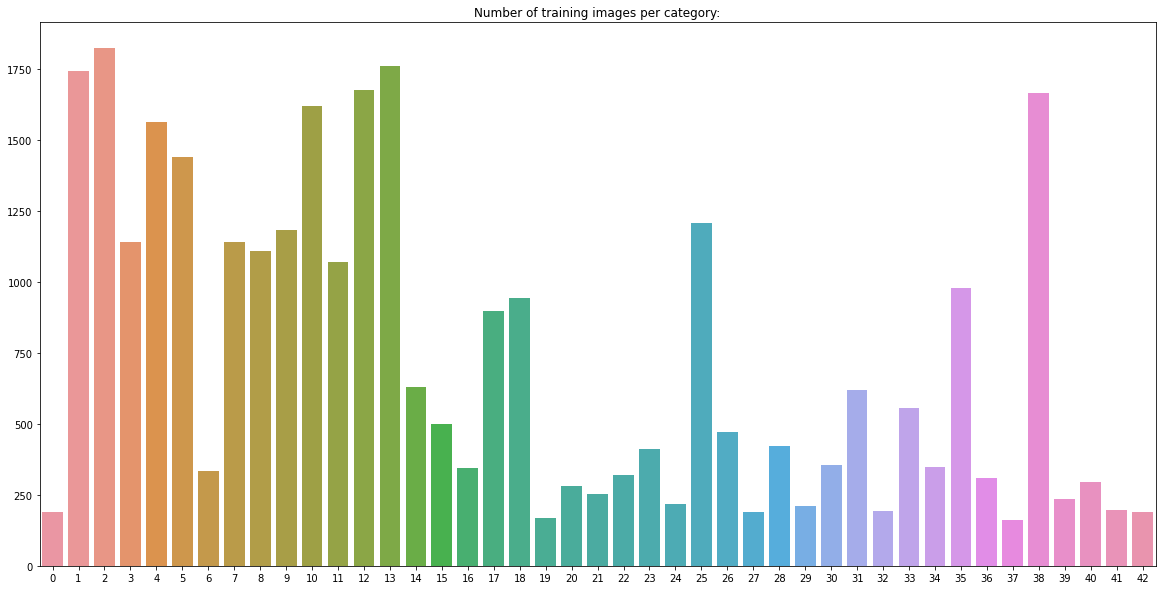

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


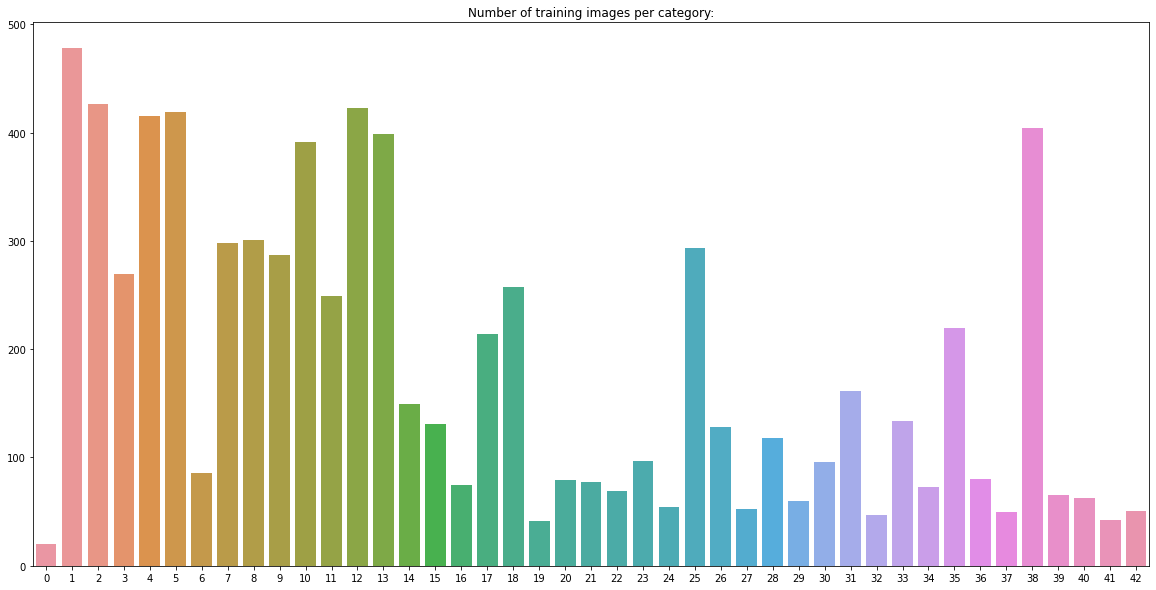

In [14]:
plot(ytrain)
plot(ytest)

In [15]:
del xtrain, xtest, ytrain, ytest

In [16]:
xtrain, xtest, ytrain, ytest = split("kennard_stone", img_data, label_data)

In [17]:
ytest.shape[0]/(ytrain.shape[0]+ytest.shape[0])

0.19997959652120686

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


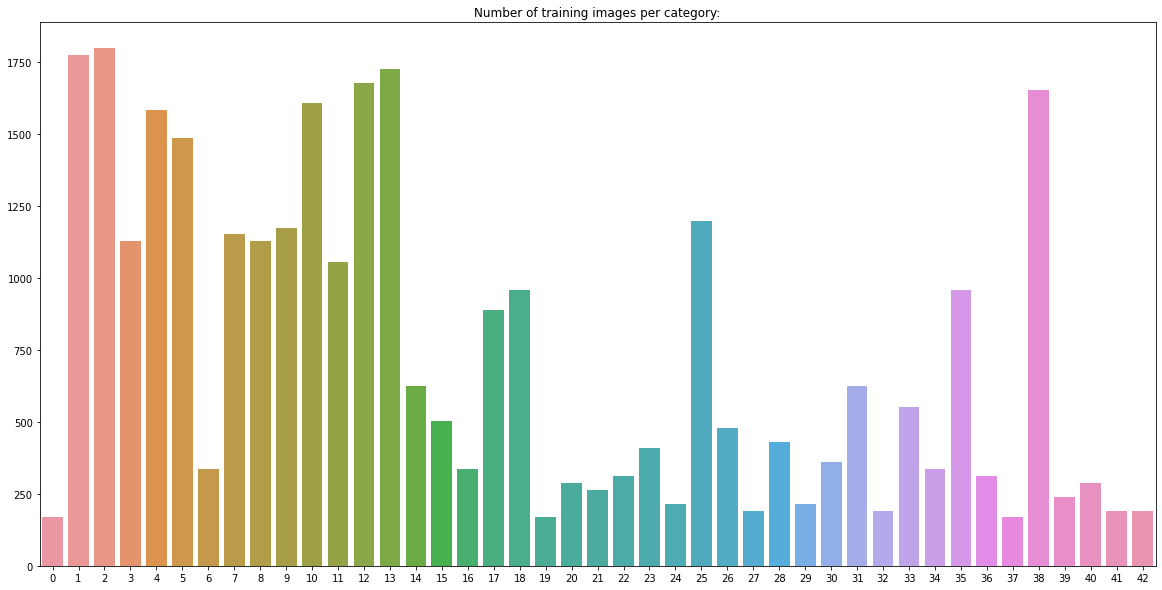

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


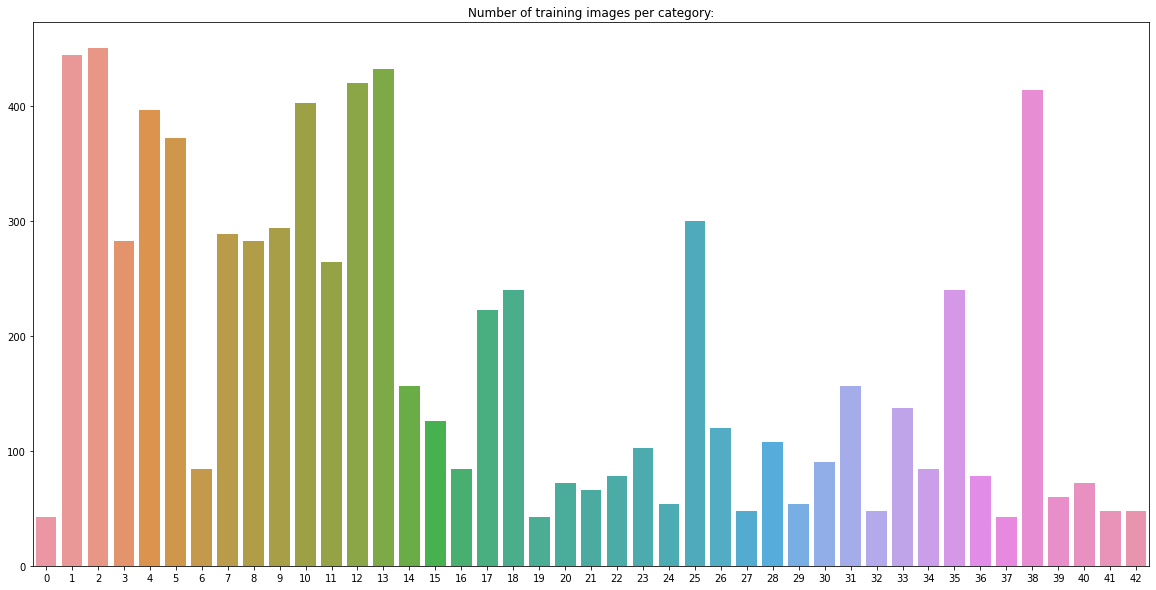

In [18]:
plot(ytrain)
plot(ytest)